In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from collections import Counter
import pickle

In [30]:
RW_dataset_path = "C:\\Users\\hp-pc\\Desktop\\GRP\\real_data\\moth\\moth_total\\moth_total.csv"

In [31]:
df_moth_RW = pd.read_csv(RW_dataset_path, index_col=False)

In [32]:
df_moth_RW

,time,posx,posy,con,detection,windv,winddir,yaw_c,yaw,yaw_error
0,1,-1.133428,-0.087199,0.0,0,0.00,180.000000,20.000000,84.979655,-64.979655
1,2,-1.133499,-0.087052,543.0,1,0.41,-124.018084,20.000000,84.981916,-64.981916
2,3,-1.133539,-0.087095,581.0,1,0.45,-120.025794,59.974206,84.974206,-25.000000
3,4,-1.130452,-0.079646,529.0,1,0.81,-108.487564,71.512436,80.512436,-9.000000
4,5,-1.108861,-0.040860,576.0,1,0.73,-114.110007,65.889992,69.889992,-4.000000
...,...,...,...,...,...,...,...,...,...,...
13694,68,-0.680270,-0.725390,642.0,0,1.63,126.753343,-67.665235,-74.246657,-6.581422
13695,69,-0.667918,-0.760249,652.0,0,2.38,117.149818,-67.665235,-73.850182,-6.184947
13696,70,-0.653904,-0.798121,635.0,0,1.49,113.611592,-67.665235,-73.388408,-5.723173
13697,71,-0.642391,-0.828852,627.0,0,1.50,99.991336,-67.665235,-73.008664,-5.343430


In [33]:
df_moth_RW = df_moth_RW.dropna()

In [34]:
df_moth_RW.pop('time')
df_moth_RW.pop('posx')
df_moth_RW.pop('posy')
df_moth_RW.pop('yaw')
df_moth_RW.pop('yaw_error')

0       -64.979655
1       -64.981916
2       -25.000000
3        -9.000000
4        -4.000000
           ...    
13694    -6.581422
13695    -6.184947
13696    -5.723173
13697    -5.343430
13698    -5.063220
Name: yaw_error, Length: 13699, dtype: float64

In [35]:
def change_yaw(x):
    if x < 0:
        x += 360
    return x
df_moth_RW['yaw_c'] = df_moth_RW['yaw_c'].apply(change_yaw)
yaw_c_RW = df_moth_RW.pop("yaw_c")
yaw_c_RW = yaw_c_RW * np.pi / 180 # deg to rad

df_moth_RW['Cx'] = np.cos(yaw_c_RW)
df_moth_RW['Cy'] = np.sin(yaw_c_RW)

In [36]:
def change_winddir(x):
    if x < 0:
        x += 360
    return x

df_moth_RW['winddir'] = df_moth_RW['winddir'].apply(change_winddir)
winddir = df_moth_RW.pop("winddir")
winddir = winddir * np.pi / 180

df_moth_RW['windvx'] = df_moth_RW['windv']*np.cos(winddir)
df_moth_RW['windvy'] = df_moth_RW['windv']*np.sin(winddir)

In [37]:
winddir = df_moth_RW.pop("windv")

In [38]:
df_moth_RW = df_moth_RW[['windvx', 'windvy', 'con', 'detection', 'Cx', 'Cy']]

In [39]:
mean = df_moth_RW.mean()
std = df_moth_RW.std()
df_moth_RW = (df_moth_RW - mean) / std

In [40]:
train_df = df_moth_RW[0:int(len(df_moth_RW) * 0.8)]
val_df = df_moth_RW[int(len(df_moth_RW) * 0.8):int(len(df_moth_RW) * 0.9)]
test_df = df_moth_RW[int(len(df_moth_RW) * 0.9):]

In [41]:
# define the window_generator function
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df, val_df, test_df,
                 label_columns=None,
                 input_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        self.input_columns = input_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column names: {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=16, )

        ds = ds.map(self.split_window)

        return ds
    
    # convert DataFrame into Dataset
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    # fetch an example batch for plotting
    def example(self):
        # by default, call example function returns None
        result = getattr(self, '_example', None)
        if result is None:
            # no example batch was found, so get one from the '.train' dataset
            # iter: creates an iterator object
            result = next(iter(self.train))
            # and cache it for the next time
            self._example = result

        return result

    def plot(self, model=None, plot_col='Yaw_e', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        # find the index of the column that the user wants to plot
        plot_col_index = self.column_indices[plot_col]
        # only plots maximal 3 batches of data
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n + 1)
            plt.ylabel(f'{plot_col}[normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                # get: method returns the value of the item (index) with the specified key (name)
                # get(keyname, value=None)
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                # with the continue statement, we can stop the current iteration of the for loop
                # and continue with the next
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k',
                        label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)
            if n == 0:
                plt.legend()

        plt.xlabel('Time[s]')
        plt.show()


In [42]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                        validation_data=window.val,
                        callbacks=[early_stopping])
    return history


In [43]:
columns = df_moth_RW.columns
label_columns = ['Cx', 'Cy']
input_columns = list((Counter(columns) - Counter(label_columns)).elements())
num_inputs = len(input_columns)

In [44]:
# CNN model
CONV_WIDTH = 6

kernel_size1 = int((CONV_WIDTH+3)/3)
kernel_size2 = int((CONV_WIDTH+3)/3)
kernel_size3 = int((CONV_WIDTH+3)/3 - 1)
kernel_size4 = int(CONV_WIDTH/4)

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size1,
                           activation='relu',
                           input_shape=(CONV_WIDTH, num_inputs)),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size2,
                           activation='relu'),
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=kernel_size3,
                           activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=2),
])

In [45]:
CONV_WIDTH = 6

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=CONV_WIDTH,
    shift=0,
    train_df=train_df,
    test_df=test_df,
    val_df=val_df,
    label_columns=label_columns,
    input_columns=input_columns
)

In [46]:
history = compile_and_fit(conv_model, conv_window)

val_performance = conv_model.evaluate(conv_window.test)
print(val_performance, sum(val_performance))

Epoch 1/20
685/685 [==============================] - 7s 5ms/step - loss: 0.3763 - mean_absolute_error: 0.3885 - val_loss: 0.2615 - val_mean_absolute_error: 0.3312
Epoch 2/20
685/685 [==============================] - 3s 5ms/step - loss: 0.3136 - mean_absolute_error: 0.3346 - val_loss: 0.2531 - val_mean_absolute_error: 0.3257
Epoch 3/20
685/685 [==============================] - 4s 6ms/step - loss: 0.2988 - mean_absolute_error: 0.3231 - val_loss: 0.2507 - val_mean_absolute_error: 0.3074
Epoch 4/20
685/685 [==============================] - 4s 6ms/step - loss: 0.2934 - mean_absolute_error: 0.3186 - val_loss: 0.2530 - val_mean_absolute_error: 0.3071
Epoch 5/20
685/685 [==============================] - 4s 6ms/step - loss: 0.2836 - mean_absolute_error: 0.3104 - val_loss: 0.2486 - val_mean_absolute_error: 0.3270
Epoch 6/20
685/685 [==============================] - 4s 6ms/step - loss: 0.2758 - mean_absolute_error: 0.3045 - val_loss: 0.2409 - val_mean_absolute_error: 0.2920
Epoch 7/20
685/6

In [47]:
acc = history.history['mean_absolute_error']
val_acc = history.history['val_mean_absolute_error']

loss = history.history['loss']
val_loss = history.history['val_loss']

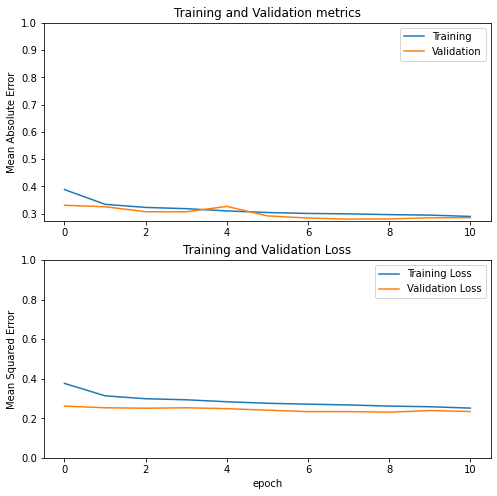

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='upper right')
plt.ylabel('Mean Absolute Error')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation metrics')


plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Mean Squared Error')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig("RW_moth_rnn.jpg")
plt.show()


In [49]:
output = plt.figure

plt.savefig("output.jpg")

<Figure size 432x288 with 0 Axes>

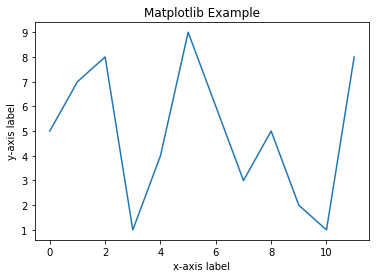

In [50]:
import matplotlib.pyplot as plt
 
# data for plotting
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
y = [5, 7, 8, 1, 4, 9, 6, 3, 5, 2, 1, 8]
 
plt.plot(x, y)
 
plt.xlabel('x-axis label')
plt.ylabel('y-axis label')
plt.title('Matplotlib Example')
 
plt.savefig("output.jpg")